# STOCK/CRPYTO PRICE PREDICTION MODEL

## The following code is an example on how to use simple data analysis tolls in order to set up a simple strategy for long and short term financial trading

### We will make use of the programing language python (3.x) which suits nicely for data anlysis

## --> This a very is simplified model for trading. One should always invest just as much money as one can afford to loose and do own studies in advance. 

## Required modules:
- numpy: the code is designed to be vectorized such that the numpy module can be used and calculations performed fast
- pandas: module for illustrative data frames
- yfinance: api module provided by yahoo finance to get current and previous asset prices
- matplotlib: (sub)module(s) for plots
- scipy: (sub)module for statistical and signal analysis
- datetime: (optional)

In [1]:
%load_ext autoreload
%autoreload 2

In [253]:
from model import MODEL
import utils, plotting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [260]:
tickers = ['BTC-USD', 'LTC-USD', 'XRP-USD']
#fix this for eval_model():
tickers = 'BTC-USD'
model = MODEL(tickers=tickers)

In [261]:
start_date = '2020-01-01'
model.get_data(start=start_date, interval='60m')

[*********************100%***********************]  1 of 1 completed


In [262]:
day_hour = 9
start_date_range = pd.Timestamp(2020, 1, 1, day_hour)
date_range = utils.create_date_range(start_date=start_date_range)
model.apply_date_filter(date_range)
model.data.tail()

[INFO]: filter applied.


,BTC-USD
Datetime,
2020-04-12 09:00:00+01:00,6846.942871
2020-04-13 09:00:00+01:00,6712.749023
2020-04-14 09:00:00+01:00,6800.395508
2020-04-15 09:00:00+01:00,6863.535156
2020-04-16 09:00:00+01:00,6987.516602


In [263]:
model.eval_model()

|                                  PRICE MODEL                                   |
|                                  Version 0.3                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                              ticker = ['BTC-USD']                              |
|                             start date = 01/01/20                              |
|                              end date = 04/16/20                               |
|                      initial investment per ticker = 200                       |
[INIT]: Initialising model for tickers: ['BTC-USD']
[INIT]: Successfully initialized model.
**********************************************************************************
[TICKER]: BTC-USD
[INFO]: Open position.
[INFO]: No tax paid.
[INFO]: Last entry of "Sell Dates" will be assigned equally as the penultimate one.
---------------

In [251]:
model.data

,BTC-USD
Datetime,
2020-01-01 09:00:00+00:00,7196.809570
2020-01-02 09:00:00+00:00,7157.130859
2020-01-03 09:00:00+00:00,7384.239746
2020-01-04 09:00:00+00:00,7380.282227
2020-01-05 09:00:00+00:00,7468.565918
...,...
2020-04-12 09:00:00+01:00,6846.942871
2020-04-13 09:00:00+01:00,6712.749023
2020-04-14 09:00:00+01:00,6800.395508


In [252]:
model.ticker_df['BTC-USD']

,Buy Dates,Sell Dates,Buy Prices,Sell Prices,Trade Reward,Trade Win,Trade Efficiency
0,2020-01-10 09:00:00,2020-01-12 09:00:00,7767.397819,8112.459452,208.884871,8.884871,0.044424
1,2020-01-13 09:00:00,2020-01-15 09:00:00,8162.041417,8705.163772,222.784585,13.899714,0.066542
2,2020-01-21 09:00:00,2020-01-24 09:00:00,8664.012945,8251.346914,212.173379,-10.611206,-0.047630
3,2020-01-25 09:00:00,2020-01-30 09:00:00,8379.922911,9305.028362,235.596356,23.422978,0.110395
4,2020-02-06 09:00:00,2020-02-08 09:00:00,9655.628361,9736.038506,237.558356,1.961999,0.008328
5,2020-02-09 09:00:00,2020-02-10 09:00:00,10098.225564,9769.104450,229.815860,-7.742496,-0.032592
6,2020-02-12 09:00:00,2020-02-14 09:00:00,10298.286485,10151.061982,226.530408,-3.285452,-0.014296
7,2020-02-19 09:00:00,2020-02-20 09:00:00,10147.531223,9566.442371,213.558357,-12.972051,-0.057264
8,2020-02-22 09:00:00,2020-02-25 09:00:00,9645.634619,9546.512013,211.363741,-2.194616,-0.010276
9,2020-02-28 09:00:00,2020-03-07 09:00:00,8667.680777,9093.524331,221.748051,10.384310,0.049130


In [280]:
start_plot_range = pd.Timestamp(2020, 4, 1, day_hour)
plot_range = utils.create_date_range(start_date=start_plot_range)
print(plot_range)

DatetimeIndex(['2020-04-01 09:00:00+01:00', '2020-04-02 09:00:00+01:00',
               '2020-04-03 09:00:00+01:00', '2020-04-04 09:00:00+01:00',
               '2020-04-05 09:00:00+01:00', '2020-04-06 09:00:00+01:00',
               '2020-04-07 09:00:00+01:00', '2020-04-08 09:00:00+01:00',
               '2020-04-09 09:00:00+01:00', '2020-04-10 09:00:00+01:00',
               '2020-04-11 09:00:00+01:00', '2020-04-12 09:00:00+01:00',
               '2020-04-13 09:00:00+01:00', '2020-04-14 09:00:00+01:00',
               '2020-04-15 09:00:00+01:00', '2020-04-16 09:00:00+01:00'],
              dtype='datetime64[ns, Europe/London]', name='Datetime', freq='D')


[15 16]
['2020-04-05T08:00:00.000000000' '2020-04-11T08:00:00.000000000']


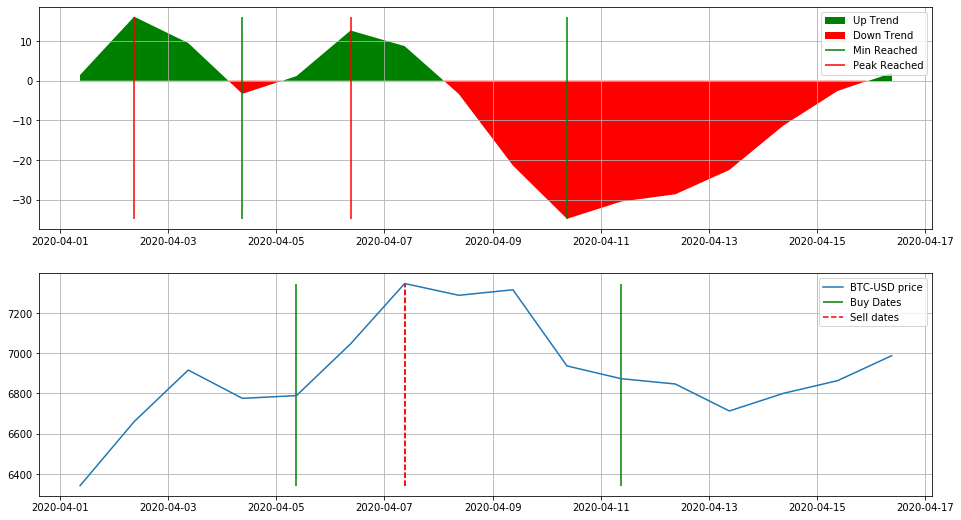

In [388]:
plotting.plot_model(model, plot_range=plot_range)

In [355]:
imag_model = model.copy_model()

In [356]:
imag_model.append_timedelta(timedelta=1)

[USER-INPUT]: Overwrite existing data? [y/n]: y
[INFO]: NaN values were append.


In [357]:
imag_model.data

,BTC-USD
2020-01-01 09:00:00+00:00,7196.809570
2020-01-02 09:00:00+00:00,7157.130859
2020-01-03 09:00:00+00:00,7384.239746
2020-01-04 09:00:00+00:00,7380.282227
2020-01-05 09:00:00+00:00,7468.565918
...,...
2020-04-13 09:00:00+01:00,6712.749023
2020-04-14 09:00:00+01:00,6800.395508
2020-04-15 09:00:00+01:00,6863.535156
2020-04-16 09:00:00+01:00,6987.516602


In [358]:
imag_model.comp_break_values(['BTC-USD', 'LTC-USD'])

[WARNING]: Ticker "LTC-USD" not in available tickers
[INFO]: Compute break values with 30.00% deviation
[USER INPUT]: Append breaking values w.r.t smallest tolerances? n
[INFO]: Current values: {'BTC-USD': 6987.5166015625}
[INFO]: Break values: {'BTC-USD': [7023.8516878904, 6878.5113425779155]}
[INFO]: Tolerances: {'BTC-USD': array([-36.33508633, 109.00525898])}


In [359]:
imag_model.data

,BTC-USD
2020-01-01 09:00:00+00:00,7196.809570
2020-01-02 09:00:00+00:00,7157.130859
2020-01-03 09:00:00+00:00,7384.239746
2020-01-04 09:00:00+00:00,7380.282227
2020-01-05 09:00:00+00:00,7468.565918
...,...
2020-04-13 09:00:00+01:00,6712.749023
2020-04-14 09:00:00+01:00,6800.395508
2020-04-15 09:00:00+01:00,6863.535156
2020-04-16 09:00:00+01:00,6987.516602


In [360]:
imag_model.eval_model(tickers=['BTC-USD', 'LTC-USD'])

[WARNING]: Ticker "LTC-USD" not in available tickers
|                                  PRICE MODEL                                   |
|                                  Version 0.3                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                              ticker = ['BTC-USD']                              |
|                             start date = 01/01/20                              |
|                              end date = 04/17/20                               |
|                      initial investment per ticker = 200                       |
[TICKER]: BTC-USD
[INFO]: Open position.
[INFO]: No tax paid.
[INFO]: Last entry of "Sell Dates" will be assigned equally as the penultimate one.
----------------------------------------------------------------------------------
[SUMMARY]: Average trade win: 8.6307381588%
[SUMMARY]:

In [361]:
imag_model.ticker_df['BTC-USD']

,Buy Dates,Sell Dates,Buy Prices,Sell Prices,Trade Reward,Trade Win,Trade Efficiency
0,2020-01-05 09:00:00,2020-01-08 09:00:00,7490.224759,8276.017087,220.981809,20.981809,0.104909
1,2020-01-10 09:00:00,2020-01-12 09:00:00,7767.397819,8112.459452,230.798783,9.816974,0.044424
2,2020-01-13 09:00:00,2020-01-15 09:00:00,8162.041417,8705.163772,246.156703,15.357920,0.066542
3,2020-01-21 09:00:00,2020-01-22 09:00:00,8664.012945,8649.645921,245.748516,-0.408187,-0.001658
4,2020-01-24 09:00:00,2020-01-29 09:00:00,8313.518003,9284.070526,274.438156,28.689640,0.116744
5,2020-02-05 09:00:00,2020-02-07 09:00:00,9280.973715,9731.678771,287.765493,13.327337,0.048562
6,2020-02-08 09:00:00,2020-02-09 09:00:00,9809.396241,10022.707874,294.023139,6.257646,0.021746
7,2020-02-11 09:00:00,2020-02-13 09:00:00,9827.351481,10113.433140,302.582376,8.559237,0.029111
8,2020-02-18 09:00:00,2020-02-19 09:00:00,9754.085914,10071.644810,312.433399,9.851023,0.032556
9,2020-02-21 09:00:00,2020-02-24 09:00:00,9700.601179,9685.207005,311.937589,-0.495810,-0.001587


In [362]:
imag_model.break_values

{'BTC-USD': [7023.8516878904, 6878.5113425779155]}

In [363]:
imag_model.data

,BTC-USD
2020-01-01 09:00:00+00:00,7196.809570
2020-01-02 09:00:00+00:00,7157.130859
2020-01-03 09:00:00+00:00,7384.239746
2020-01-04 09:00:00+00:00,7380.282227
2020-01-05 09:00:00+00:00,7468.565918
...,...
2020-04-13 09:00:00+01:00,6712.749023
2020-04-14 09:00:00+01:00,6800.395508
2020-04-15 09:00:00+01:00,6863.535156
2020-04-16 09:00:00+01:00,6987.516602


In [364]:
imag_model.data['BTC-USD'][-1] = 6687#imag_model.break_values['BTC-USD'][0] - 1
imag_model._init_model()
imag_model.data.tail(1)

[INIT]: Initialising model for tickers: ['BTC-USD']
[INIT]: Successfully initialized model.
**********************************************************************************


,BTC-USD
2020-04-17 09:00:00+01:00,6687.0


In [365]:
imag_model.eval_model(tickers=['BTC-USD'])

|                                  PRICE MODEL                                   |
|                                  Version 0.3                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                              ticker = ['BTC-USD']                              |
|                             start date = 01/01/20                              |
|                              end date = 04/17/20                               |
|                      initial investment per ticker = 200                       |
[TICKER]: BTC-USD
[INFO]: No tax paid.
----------------------------------------------------------------------------------
[SUMMARY]: Average trade win: 8.0785976496%
[SUMMARY]: Average trade loss: -0.6210596913%
[SUMMARY]: Efficiency: 82.35%
[SUMMARY]: NET WIN: 367.37


In [366]:
imag_model.ticker_df['BTC-USD']

,Buy Dates,Sell Dates,Buy Prices,Sell Prices,Trade Reward,Trade Win,Trade Efficiency
0,2020-01-05 09:00:00,2020-01-08 09:00:00,7490.224759,8276.017087,220.981809,20.981809,0.104909
1,2020-01-10 09:00:00,2020-01-12 09:00:00,7767.397819,8112.459452,230.798783,9.816974,0.044424
2,2020-01-13 09:00:00,2020-01-15 09:00:00,8162.041417,8705.163772,246.156703,15.357920,0.066542
3,2020-01-21 09:00:00,2020-01-22 09:00:00,8664.012945,8649.645921,245.748516,-0.408187,-0.001658
4,2020-01-24 09:00:00,2020-01-29 09:00:00,8313.518003,9284.070526,274.438156,28.689640,0.116744
5,2020-02-05 09:00:00,2020-02-07 09:00:00,9280.973715,9731.678771,287.765493,13.327337,0.048562
6,2020-02-08 09:00:00,2020-02-09 09:00:00,9809.396241,10022.707874,294.023139,6.257646,0.021746
7,2020-02-11 09:00:00,2020-02-13 09:00:00,9827.351481,10113.433140,302.582376,8.559237,0.029111
8,2020-02-18 09:00:00,2020-02-19 09:00:00,9754.085914,10071.644810,312.433399,9.851023,0.032556
9,2020-02-21 09:00:00,2020-02-24 09:00:00,9700.601179,9685.207005,311.937589,-0.495810,-0.001587


In [435]:
start = imag_model.data['BTC-USD'].index.get_loc(plot_range[0])
imag_plot_range = imag_model.data.index[start:]

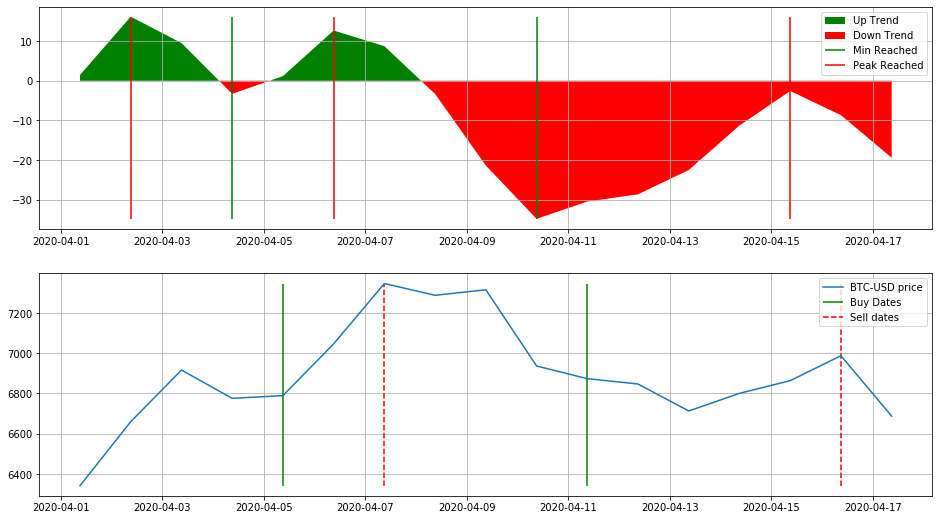

In [436]:
plotting.plot_model(imag_model, plot_range=imag_plot_range)

In [392]:
imag_model.data

,BTC-USD
2020-01-01 09:00:00+00:00,7196.809570
2020-01-02 09:00:00+00:00,7157.130859
2020-01-03 09:00:00+00:00,7384.239746
2020-01-04 09:00:00+00:00,7380.282227
2020-01-05 09:00:00+00:00,7468.565918
...,...
2020-04-13 09:00:00+01:00,6712.749023
2020-04-14 09:00:00+01:00,6800.395508
2020-04-15 09:00:00+01:00,6863.535156
2020-04-16 09:00:00+01:00,6987.516602
